# Avoiding Bubbles with VolQ Risk-Off Recommendation
---
Here we use the same LPPLS indicator but we substitute the @VolitlityQ Risk Off portfolio. Outlined here:

- Long: VXX IEI SHY SHV BIL GLD UUP FXF FXY 
- Short: TLT EMB DBC GSG GDX REM VNQ IWM DIA SPY QQQ EEM VGK HYG LQD IGSB BITO

With the Caveat:
Some of these assets classes should NOT be traded via ETFs.

In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
from lppls import lppls
import numpy as np
from os.path import exists
import pandas as pd
import time
import yfinance as yf
from utils import plotting as plt_u # import utility functions for plotting 

%matplotlib inline

START = '2004-01-30'
END = '2021-11-24'
LOOKBACK = 21 * 6 # 21 days in a trading month
UNIVERSE_CSV = 'data/universeVolQ.csv'
LPPLS_CONF_CSV = 'data/confidence.csv'
CPU_CORES = max(1, cpu_count() // 2)  # only let the LPPLS number cruncher use half the available cores
POS_BUBBLE_THRESHOLD = 0.08
NEG_BUBBLE_THRESHOLD = -0.02
MAX_VIX_RATIO_THRESHOLD = 1.1
MIN_VIX_RATIO_THRESHOLD = 0.9
MAX_VIX = 35

## Fetching Universe Data (Yahoo! Finance)

Yahoo! Finance computes an Adjusted Closing price that factors in all splits and dividends. 
https://help.yahoo.com/kb/SLN28256.html

In [2]:
tickers = ['TLT', 'VTI', 'VTV', 'VBR', 'AGG', '^VIX', '^VIX3M', 'SPY'] 

shorts = ['TLT', 'EMB', 'IWM', 'DIA', 'SPY', 'EEM', 'VGK', 'REM', 'VNQ', 'DMC', 'GSG', 'GDX', 'BITO', 'LQD', 'IGSB', 'HYG']
longs = ['IEI', 'SHY', 'BIL', 'UUP', 'FXF', 'FXY', 'VXX', 'GLD']

portfolioVolQ = longs + shorts

portfolioVolQwReturnString = [f'{col} Returns' for col in portfolioVolQ]

if not exists(UNIVERSE_CSV):
    print('fetch data from Yahoo! Finance')
    adj_close_list = []
    for ticker in tickers + portfolioVolQ:
        ticker_module = yf.Ticker(ticker)
        data = yf.download(ticker, start=START, end=END)
        adj_close = data['Adj Close']
        adj_close.rename(f'{ticker} Adj Close', inplace=True)
        adj_close_list.append(adj_close)
    # combine all dataframes into a single dataframe
    df_adj_close = pd.concat(adj_close_list, axis=1)
    df_adj_close.to_csv(UNIVERSE_CSV)
else:
    print('load data from cache')
    df_adj_close = pd.read_csv(UNIVERSE_CSV, index_col='Date', parse_dates=True)

load data from cache


In [3]:
research_factors = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True)
factors_df = research_factors[START:END]  # filter rows by backtest dates

# convert the annulaized risk-free rate of return (average over backtest lifetime) to daily
RISK_FREE_RATE = factors_df['RF'].mean()/252
print('RISK_FREE_RATE = {:.5f}%'. format(RISK_FREE_RATE * 100))

RISK_FREE_RATE = 0.00184%


## Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns

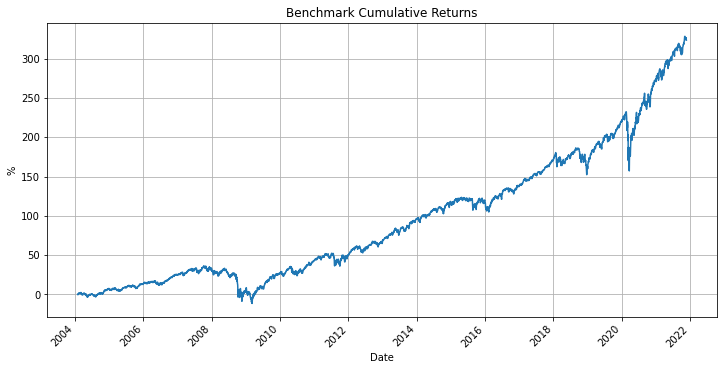

Benchmark Cumulative Returns: 323.69%


In [4]:
# get daily returns and change col names
df_pct_change = df_adj_close.pct_change().fillna(0)
df_pct_change.columns = [col.replace(' Adj Close', ' Returns') for col in df_pct_change.columns]

# call it df_D, D for Daily
df_D = df_pct_change

# create a 60/40 benchmark to compare portfolio returns against through out analysis.
df_D['Benchmark Returns'] = (
    (0.6 * df_D['VTI Returns']) + (0.4 * df_D['AGG Returns'])
)
# df_D['Benchmark Returns'] = (df_D['SPY Returns'])

# visualize the portfolio v benchmark
(((1+df_D['Benchmark Returns']).cumprod()-1)*100).plot(
    figsize=(12,6),
    title='Benchmark Cumulative Returns'
)
plt.ylabel('%')
plt.grid()
plt.xticks(rotation=45)
plt.show()
benchmark_cumulative_return = round(((1+df_D['Benchmark Returns']).cumprod()[-1]-1)*100, 2)
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')

## Compute LPPLS-CI for $VTI
---

In [5]:
# convert Date to ordinal, that's what the LPPLS model wants - it's a neat trick for curve-fitting with time-series
time_ord = [pd.Timestamp.toordinal(t1) for t1 in df_adj_close.index]

# create list of observation data
price = np.log(df_adj_close['VTI Adj Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time_ord, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the VTI data
lppls_model = lppls.LPPLS(observations=observations)

load LPPLS conf scores from cache


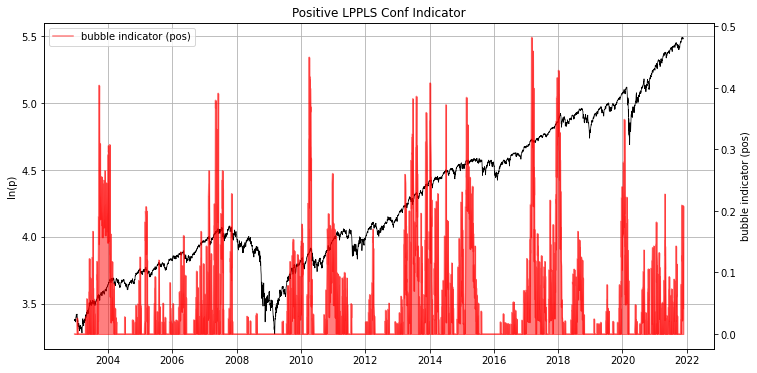

In [6]:
# compute the indicators and cache the result
if not exists(LPPLS_CONF_CSV):
    print('compute LPPLS conf scores fresh')
    # compute the confidence indicator
    res = lppls_model.mp_compute_nested_fits(
        workers=CPU_CORES,
        window_size=126*3, 
        smallest_window_size=21, 
        outer_increment=1, 
        inner_increment=5, 
        max_searches=25,
        # filter_conditions_config={} # not implemented in 0.6.x
    )
    res_df = lppls_model.compute_indicators(res)
    res_df['time'] = [pd.Timestamp.fromordinal(int(t1)) for t1 in res_df['time']]
    res_df.set_index('time', inplace=True)
    res_df.to_csv(LPPLS_CONF_CSV)
else:
    print('load LPPLS conf scores from cache')
    res_df = pd.read_csv(LPPLS_CONF_CSV, index_col='time', parse_dates=True)
    
# visualize the conf indicator   
plt_u.plot_pos_confidence_indicators(res_df)

count    3868.000000
mean        0.910491
std         0.087156
min         0.710358
25%         0.850193
50%         0.899019
75%         0.957108
max         1.430922
Name: v_ratio, dtype: float64


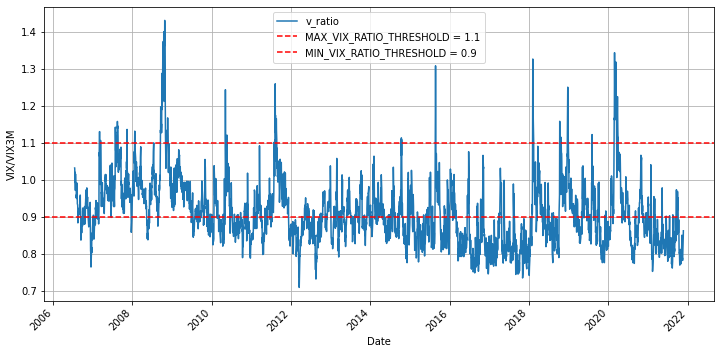

In [7]:
df_D['v_ratio'] = df_adj_close['^VIX Adj Close'] / df_adj_close['^VIX3M Adj Close'] 
df_D['vix_spot'] = df_adj_close['^VIX Adj Close']
print(df_D['v_ratio'].describe())
df_D['v_ratio'].plot(figsize=(12,6))
plt.ylabel('VIX/VIX3M')
plt.axhline(MAX_VIX_RATIO_THRESHOLD, color='red', ls='--', label=f'MAX_VIX_RATIO_THRESHOLD = {MAX_VIX_RATIO_THRESHOLD}')
plt.axhline(MIN_VIX_RATIO_THRESHOLD, color='red', ls='--', label=f'MIN_VIX_RATIO_THRESHOLD = {MIN_VIX_RATIO_THRESHOLD}')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

count    4487.000000
mean       18.909425
std         9.039391
min         9.140000
25%        13.200000
50%        16.209999
75%        21.565000
max        82.690002
Name: vix_spot, dtype: float64


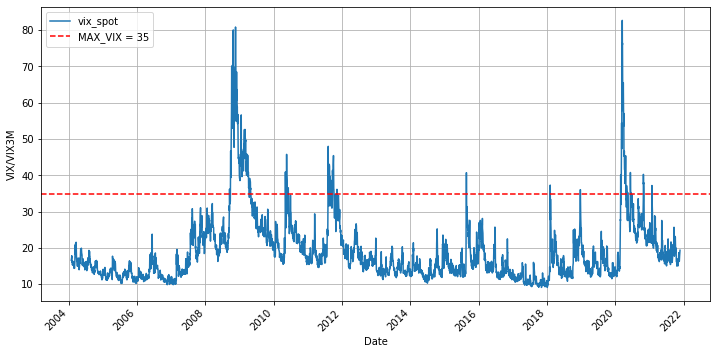

In [8]:
print(df_D['vix_spot'].describe())
df_D['vix_spot'].plot(figsize=(12,6))
plt.ylabel('VIX/VIX3M')
plt.axhline(MAX_VIX, color='red', ls='--', label=f'MAX_VIX = {MAX_VIX}')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

<ipython-input-9-53439f1cc765>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bp_df['Bubble Portfolio Returns'] = np.select(conditions, portfolio)
<ipython-input-9-53439f1cc765>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bp_df['VolQ Portfolio Returns'] = np.select(conditions, volQ_portfolio)


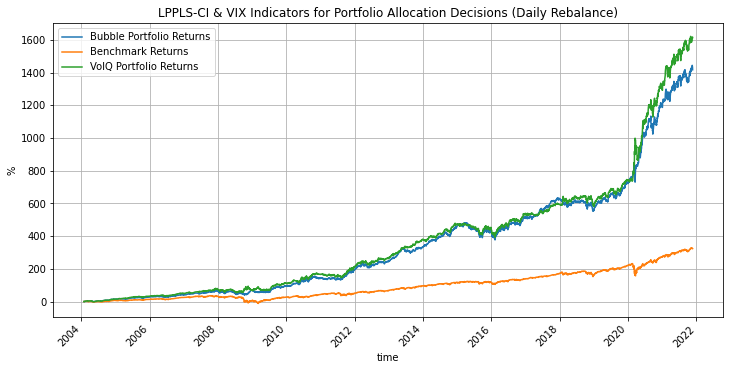

VolQ Portfolio Cumulative Returns: 1613.78%
Bubble Portfolio Cumulative Returns: 1417.63%
Benchmark Cumulative Returns: 323.69%


In [9]:
pos_conf_df = res_df.drop(['price', '_fits'], axis=1)
bubble_portfolio_df = pos_conf_df.join(df_D)
# bubble_portfolio_df = bubble_portfolio_df[START:END]
bubble_portfolio_df['conf'] = bubble_portfolio_df['pos_conf'] - bubble_portfolio_df['neg_conf']

# prevent lookahead bias: use conf and v_ratio score from 2 days ago today. 
# Note on why shift 2 is needed (thanks @choffstein):
# > Indicators can't be generated until AFTER the close.
# > Returns are close-to-close.  
# > To actually achieve those returns, 
# > you’d need to put your trade on AT the close.
# > But, what’s more likely is that you put your trade on at the next close. 
# > In which case you achieve the returns 2 days forward.
bubble_portfolio_df['conf'] = bubble_portfolio_df['conf'].shift(2)
bubble_portfolio_df['v_ratio'] = bubble_portfolio_df['v_ratio'].shift(2)
bp_df = bubble_portfolio_df[START:END]

# # group indicators by month and take the mean, 
# # TODO: it would be better to weight most recent observations heavier
# conf_M = bubble_portfolio_df['conf'].groupby(pd.Grouper(freq='M')).mean() 
# v_ratio_M = bubble_portfolio_df['v_ratio'].groupby(pd.Grouper(freq='M')).mean() 

# # reintegrate monthly data to bubble_portfolio_df and forward fill the indicator, 
# # the previous month's mean pos_conf will determine what we do all next month
# bp_df = bubble_portfolio_df.join([conf_M.rename('conf_M', inplace=True), v_ratio_M.rename('v_ratio_M', inplace=True)])
# bp_df['conf_M'] = bp_df['conf_M'].fillna(method='ffill')
# bp_df['v_ratio_M'] = bp_df['v_ratio_M'].fillna(method='ffill')
# bp_df = bp_df[START:END]

# print(bp_df['conf_M'].describe())
# print(bp_df['v_ratio_M'].describe())

# a variety of allocation rules to try...
# it seems that combined is best, nice
lppls_ci_only_allocation_rules = [
    (bp_df['conf'] >= POS_BUBBLE_THRESHOLD), 
    (bp_df['conf'] <= NEG_BUBBLE_THRESHOLD),
    ((bp_df['conf'] < POS_BUBBLE_THRESHOLD) & (bp_df['conf'] > NEG_BUBBLE_THRESHOLD))
]
vix_only_allocation_rules = [
    ((bp_df['v_ratio'] >= MAX_VIX_RATIO_THRESHOLD) | (bp_df['vix_spot'] >= MAX_VIX)), 
    (bp_df['v_ratio'] <= MIN_VIX_RATIO_THRESHOLD),
    ((bp_df['v_ratio'] < MAX_VIX_RATIO_THRESHOLD) & (bp_df['vix_spot'] < MAX_VIX) & (bp_df['v_ratio']  > MIN_VIX_RATIO_THRESHOLD))
]
combined_allocation_rules = [
    ((bp_df['conf'] >= POS_BUBBLE_THRESHOLD) | (bp_df['v_ratio'] >= MAX_VIX_RATIO_THRESHOLD) | (bp_df['vix_spot'] > MAX_VIX)), 
    ((bp_df['conf'] <= NEG_BUBBLE_THRESHOLD) | (bp_df['v_ratio']  <= MIN_VIX_RATIO_THRESHOLD)),
    ((bp_df['conf'] < POS_BUBBLE_THRESHOLD) & (bp_df['conf'] > NEG_BUBBLE_THRESHOLD))
]

conditions = combined_allocation_rules

portfolio = [
    (   # ⬇️ Risk Off
        (0.0 * bp_df['VTI Returns']) \
        + (0.0 * bp_df['VTV Returns']) \
        + (0.0 * bp_df['VBR Returns']) \
        + (0.5 * bp_df['AGG Returns']) \
        + (0.5 * bp_df['TLT Returns']) \
    ),( # ⬇️ Risk On
        (0.333 * bp_df['VTI Returns']) \
        + (0.333 * bp_df['VTV Returns']) \
        + (0.333 * bp_df['VBR Returns']) \
        + (0.0 * bp_df['AGG Returns']) \
        + (0.0 * bp_df['TLT Returns']) \
    ),( # ⬇️ Equal Weight
        (0.2 * bp_df['VTI Returns']) \
        + (0.2 * bp_df['VTV Returns']) \
        + (0.2 * bp_df['VBR Returns']) \
        + (0.2 * bp_df['AGG Returns']) \
        + (0.2 * bp_df['TLT Returns']) \
    )
]

# simulate short returns (only for VolQ Risk-off)
bp_df2 = bp_df.copy()
for col in shorts:
    bp_df2[f'{col} Returns'] = bp_df2[f'{col} Returns'] * -1
volQ_portfolio = [
    (   # ⬇️ Risk Off
        bp_df2[portfolioVolQwReturnString].mean(axis='columns') # 🐷
    ),( # ⬇️ Risk On 
        # TODO: what are some more fun risk on instruments?
        (0.333 * bp_df['VTI Returns']) \
        + (0.333 * bp_df['VTV Returns']) \
        + (0.333 * bp_df['VBR Returns']) \
        + (0.0 * bp_df['AGG Returns']) \
        + (0.0 * bp_df['TLT Returns']) \
    ),( # ⬇️ Equal Weight
        (0.2 * bp_df['VTI Returns']) \
        + (0.2 * bp_df['VTV Returns']) \
        + (0.2 * bp_df['VBR Returns']) \
        + (0.2 * bp_df['AGG Returns']) \
        + (0.2 * bp_df['TLT Returns']) \
    )
]
bp_df['Bubble Portfolio Returns'] = np.select(conditions, portfolio)
bp_df['VolQ Portfolio Returns'] = np.select(conditions, volQ_portfolio)
# bp_df['Allocation'] = np.select(conditions, ['risk-off', 'risk-on', 'equal-weight'])

# visualize the portfolio v benchmark
(((1+bp_df[[
    'Bubble Portfolio Returns', 
    'Benchmark Returns', 
    'VolQ Portfolio Returns',
]]).cumprod()-1)*100).plot(
    figsize=(12,6),
    title='LPPLS-CI & VIX Indicators for Portfolio Allocation Decisions (Daily Rebalance)'
)
plt.ylabel('%')
plt.grid()
plt.xticks(rotation=45)
plt.show()
VolQ_cumulative_return = round(((1+bp_df['VolQ Portfolio Returns']).cumprod()[-1]-1)*100, 2)
print(f'VolQ Portfolio Cumulative Returns: {VolQ_cumulative_return}%')
portfolio_cumulative_return = round(((1+bp_df['Bubble Portfolio Returns']).cumprod()[-1]-1)*100, 2)
print(f'Bubble Portfolio Cumulative Returns: {portfolio_cumulative_return}%')
benchmark_cumulative_return = round(((1+bp_df['Benchmark Returns']).cumprod()[-1]-1)*100, 2)
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')

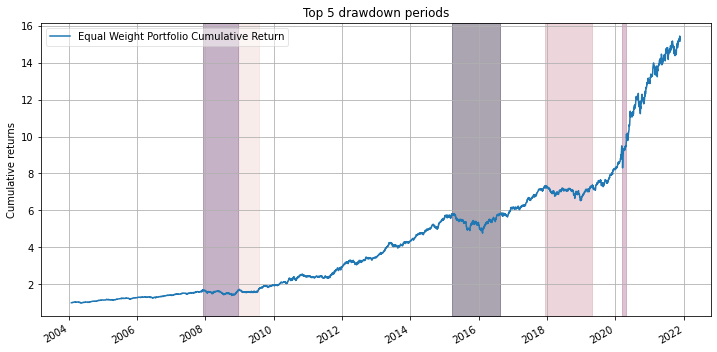

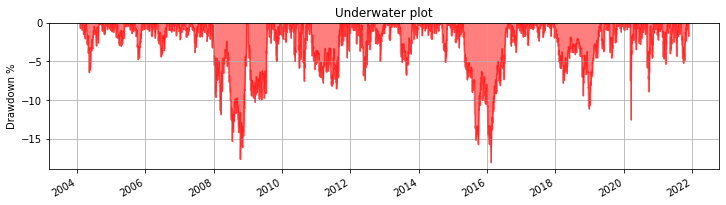

In [10]:
plt_u.plot_drawdown_periods(bp_df['Bubble Portfolio Returns'])
plt_u.plot_drawdown_underwater(bp_df['Bubble Portfolio Returns'])

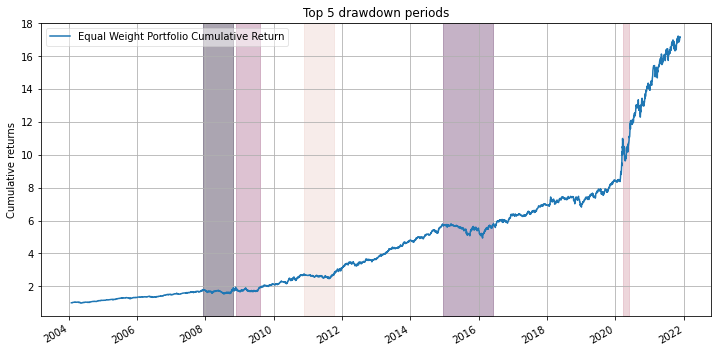

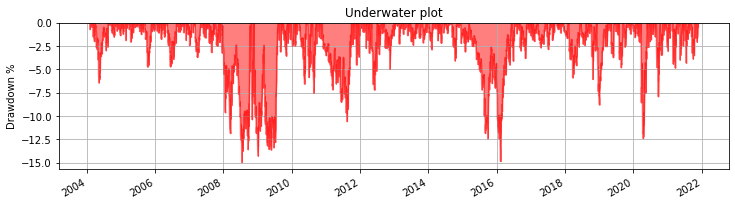

In [11]:
plt_u.plot_drawdown_periods(bp_df['VolQ Portfolio Returns'])
plt_u.plot_drawdown_underwater(bp_df['VolQ Portfolio Returns'])

If we wanted to, we could try to optimize the bubble threshold value by looking at the distribution of values. 

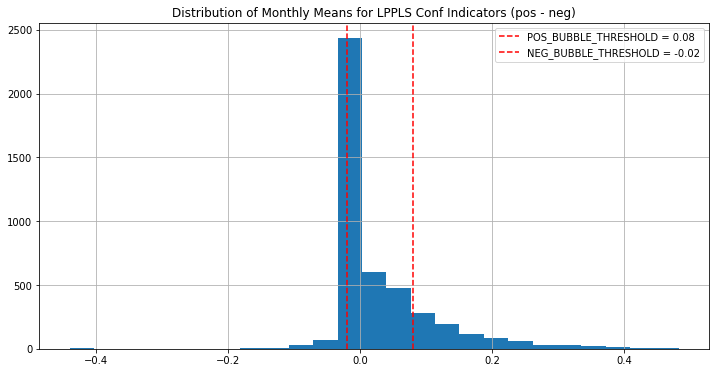

In [12]:
plt.figure(figsize=(12,6))
plt.hist(bp_df['conf'], bins=25)
plt.axvline(POS_BUBBLE_THRESHOLD, color='red', ls='--', label=f'POS_BUBBLE_THRESHOLD = {POS_BUBBLE_THRESHOLD}')
plt.axvline(NEG_BUBBLE_THRESHOLD, color='red', ls='--', label=f'NEG_BUBBLE_THRESHOLD = {NEG_BUBBLE_THRESHOLD}')
plt.title('Distribution of Monthly Means for LPPLS Conf Indicators (pos - neg)')
plt.legend()
plt.grid()
plt.show()

## Backtest Performance Summary Statistics
---

Benchmark Portfolio Sharpe Ratio (Since Inception): 0.72
Bubble Portfolio Sharpe Ratio (Since Inception): 1.36


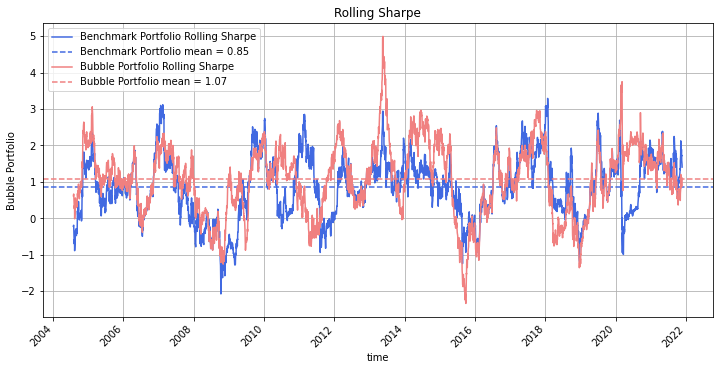

In [13]:
plt_u.plot_sharpe([
    (
        df_D['Benchmark Returns'], 
        RISK_FREE_RATE, 
        df_D['Benchmark Returns'].std(), 
        'Benchmark Portfolio',
        'royalblue',
    ), (
        bp_df['Bubble Portfolio Returns'], 
        RISK_FREE_RATE, 
        bp_df['Bubble Portfolio Returns'].std(), 
        'Bubble Portfolio',
        'lightcoral',
    )
])

In [14]:
# sharpe since inception
sharpe = (
    bp_df['Bubble Portfolio Returns'] - RISK_FREE_RATE).mean() \
    / bp_df['Bubble Portfolio Returns'].std() \
    * np.sqrt(252)

# sortino since inception
rolling_downside_std = lambda x: np.std(x[x < 0])
downside = (bp_df['Bubble Portfolio Returns'][bp_df['Bubble Portfolio Returns'] < 0])
sortino = (
    bp_df['Bubble Portfolio Returns']-RISK_FREE_RATE).mean() \
    / downside.std() \
    * np.sqrt(252)

# beta since inception
beta = bp_df[['Bubble Portfolio Returns', 'Benchmark Returns']].cov().iloc[0,1] / bp_df[['Benchmark Returns']].var().iloc[0]

correlation = (1+bp_df['Bubble Portfolio Returns']).cumprod().corr((1+bp_df['Benchmark Returns']).cumprod())

print(f'Bubble Portfolio Cumulative Returns: {portfolio_cumulative_return}%')
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')
print(f'Sharpe Ratio: {round(sharpe, 2)}')
print(f'Sortino Ratio: {round(sortino, 2)}')
print(f'Beta: {round(beta, 2)}')
print(f'Corr to SPY: {round(correlation, 2)}')

Bubble Portfolio Cumulative Returns: 1417.63%
Benchmark Cumulative Returns: 323.69%
Sharpe Ratio: 1.36
Sortino Ratio: 1.98
Beta: 0.44
Corr to SPY: 0.98


In [15]:
# sharpe since inception
sharpe = (
    bp_df['VolQ Portfolio Returns'] - RISK_FREE_RATE).mean() \
    / bp_df['VolQ Portfolio Returns'].std() \
    * np.sqrt(252)

# sortino since inception
rolling_downside_std = lambda x: np.std(x[x < 0])
downside = (bp_df['VolQ Portfolio Returns'][bp_df['VolQ Portfolio Returns'] < 0])
sortino = (
    bp_df['VolQ Portfolio Returns']-RISK_FREE_RATE).mean() \
    / downside.std() \
    * np.sqrt(252)

# beta since inception
beta = bp_df[['VolQ Portfolio Returns', 'Benchmark Returns']].cov().iloc[0,1] / bp_df[['Benchmark Returns']].var().iloc[0]

correlation = (1+bp_df['VolQ Portfolio Returns']).cumprod().corr((1+bp_df['Benchmark Returns']).cumprod())

print(f'VolQ Portfolio Cumulative Returns: {VolQ_cumulative_return}%')
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')
print(f'Sharpe Ratio: {round(sharpe, 2)}')
print(f'Sortino Ratio: {round(sortino, 2)}')
print(f'Beta: {round(beta, 2)}')
print(f'Corr to SPY: {round(correlation, 2)}')

VolQ Portfolio Cumulative Returns: 1613.78%
Benchmark Cumulative Returns: 323.69%
Sharpe Ratio: 1.36
Sortino Ratio: 1.96
Beta: 0.09
Corr to SPY: 0.98
